In [2]:
import pandas as pd
import requests, warnings
import statsmodels.formula.api as smf
import numpy as np
# import matplotlib.pyplot as plt
import statsmodels.api as sm
from tshistory.api import timeseries
import requests
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
from saturn_server.cross.refinery import RefineryData


In [3]:
tsa = timeseries('http://tst-qdev-ap9.petroineos.local/api/')

In [ ]:
def ag_get_data(query):
    warnings.simplefilter('ignore', requests.packages.urllib3.exceptions.InsecureRequestWarning)
    params = {"Database": "OIL", "Query": query}
    resp = requests.post('https://TST-QDEV-AP1.petroineos.local:5001/genericdata/Fetch/', json=params, verify=False)
    json_result = resp.json()
    df = pd.DataFrame(json_result)
    return df

In [6]:
unit_level = 'CDU'
IIR_Countries = ['Lithuania','Austria','Belgium','Denmark','Finland','France','Germany','Greece','Ireland','Italy','Netherlands','Norway','Portugal','Spain','Sweden','United Kingdom','Turkey','Czech Republic','Hungary','Poland','Slovakia','Switzerland']
NWE_countries = ['Belgium','Denmark','Finland','Germany','Ireland','Netherlands','Norway','Sweden','United Kingdom','France', 'Lithuania']
country_list = IIR_Countries
MED_countries = ['Austria','Czech Republic','Greece','Hungary','Italy','Poland','Portugal','Slovakia','Spain','Switzerland','Turkey']

In [7]:
iea_mapping = {
    'Lithuania':'LITHUANIA',
    'Austria': 'AUSTRIA',
    'Belgium':'BELGIUM',
    'Denmark':'DENMARK',
    'Finland':'FINLAND',
    'France':'FRANCE',
    'Germany':'GERMANY',
    'Greece':'GREECE',
    'Ireland':'IRELAND',
    'Italy':'ITALY',
    'Netherlands':'NETHLAND',
    'Norway':'NORWAY',
    'Portugal':'PORTUGAL',
    'Spain':'SPAIN',
    'Sweden':'SWEDEN',
    'United Kingdom':'UK',
    'Turkey':'TURKIYE',
    'Czech Republic':'CZECH',
    'Hungary':'HUNGARY',
    'Poland':'POLAND',
    'Slovakia':'SLOVAKIA',
    'Switzerland':'SWITLAND',
}

In [ ]:
capacity = RefineryData().get_capacity('COUNTRY', country_list, 'CDU').groupby(axis=1, level=0).sum()

In [ ]:
outages = RefineryData().get_outage('COUNTRY',country_list, 'CDU', exclude_cause=('Economic',)).groupby(axis=1, level=0).sum()

In [8]:
from BlueOcean import DataAccessApi

def aggregate_country_level(df):
    country_cap = df.groupby(['COUNTRY', 'DDate'])['Capacity', 'kbd_offline', 'available_capacity'].sum().reset_index()
    return country_cap

def map_iir_iso_code(df):
    iir_mapping_qry = "select * from dataengineering.oil_refinery_countrymappingiir"
    mapping = DataAccessApi.GetDataframe(iir_mapping_qry)
    country_cap_code = df.merge(mapping, how='left', left_on='COUNTRY', right_on='CountryIIR')
    country_cap_code.drop(columns='CountryIIR', inplace=True)
    return country_cap_code

def filter_non_jodi(df):
    df = df[df['RUNS']!=0]
    df2 = df[df['RUNS'].notnull()].copy()
    return df2

def get_jodi():
    jodi_qry = "select REF_AREA, TIME_PERIOD, OBS_VALUE*1000 as RUNS from dataengineering.oil_jodi_jodicrudelatest where FLOW_BREAKDOWN='REFINOBS' AND UNIT_MEASURE='KBD'  AND ENERGY_PRODUCT='CRUDEOIL' and isactive is true"
    jodi = DataAccessApi.GetDataframe(jodi_qry)
    jodi['TIME_PERIOD'] = pd.to_datetime(jodi['TIME_PERIOD']) 
    return jodi

def get_iea():
    iea_query = """
    select Country, to_date(Month, "MMMyyyy") as Date, Value 
    from hive_metastore.dataengineering.oil_iea_ieacrudebal 
    where ProductType = 'CRUDEOIL' and Flow = 'REFINOBSB' and pdate = (select max(pdate) from dataengineering.oil_iea_ieacrudebal) and isactive is true
    """
    data = DataAccessApi.GetDataframe(iea_query)
    data['Date'] = pd.to_datetime(data['Date'])
    return data

def merge_runs(capacity, jodi):
    runs = capacity.merge(jodi, how='left', left_on=['code', 'DDate'], right_on=['REF_AREA', 'TIME_PERIOD'])
    runs['utilisation'] = (runs['RUNS']/runs['available_capacity']).round(4)
    runs.drop(columns=['REF_AREA', 'TIME_PERIOD', 'code'], inplace=True)
    runs.loc[runs['utilisation'] > 1, 'utilisation'] = 1
    return runs

def get_margins():
    margins_qry = """
    select t.ddate, t.nwecomplex, t.medcomplex from dataengineering.oil_crude_euromargin t
    right join (
    select ddate, min(pdate) as pdate from dataengineering.oil_crude_euromargin
    where type = 2
    and isactive is true
    group by ddate
    ) tm on t.ddate = tm.ddate and tm.pdate = t.pdate
    """
    df = DataAccessApi.GetDataframe(margins_qry)
    df.index = pd.to_datetime(df['ddate'])
    return df.iloc[:, 1:].resample('MS').mean()

In [9]:
iir_mapping_qry = "select * from dataengineering.oil_refinery_countrymappingiir"
mapping = DataAccessApi.GetDataframe(iir_mapping_qry).set_index('CountryIIR')['code'].to_dict()

In [10]:
jodi = get_jodi()
margins = get_margins()


In [11]:
iea = get_iea()

In [12]:
iea['COUNTRY'] = iea.Country.map({v:k for k,v in iea_mapping.items()})
iea = iea.dropna(axis=0)

In [13]:
clip_margin = 5
available_capacity = (capacity - outages).resample('MS').mean()
available_capacity.index.name = 'Date'
stacked_available_capacity = available_capacity.unstack(0).rename('available_capacity')
runs = iea.assign(RUNS=lambda x: x['Value'] / x['Date'].dt.days_in_month).set_index(['COUNTRY', 'Date'])['RUNS']
data = pd.concat((stacked_available_capacity, runs),axis=1)
data.index = data.index.set_names(['COUNTRY', 'ddate'])
data = data.merge(margins[['nwecomplex','medcomplex']], how='left', left_on='ddate', right_index=True)
data = data.assign(margin=lambda x: np.where(x.index.get_level_values(0).isin(NWE_countries), x['nwecomplex'], x['medcomplex']))
data = data.assign(margin_name=lambda x: np.where(x.index.get_level_values(0).isin(NWE_countries), "oil.petroineos.euromargin.nwecomplex.usd_bbl.monthly", "oil.petroineos.euromargin.medcomplex.usd_bbl.monthly"))
data['margin'] = data['margin'].clip(upper=clip_margin)
data['slack'] = (data['available_capacity'] - data['RUNS']).clip(lower=0)
data['last_slack'] = data.groupby(axis=0, level=(0, 1)).apply(lambda grp: grp['slack'].shift(1)).droplevel([0, 1])
data = data.assign(utilisation=lambda x: (x['RUNS'] / x['available_capacity']).clip(upper=1))
data = data.query('ddate > "2010-1-1"')

NameError: name 'capacity' is not defined

<AxesSubplot: xlabel='ddate'>

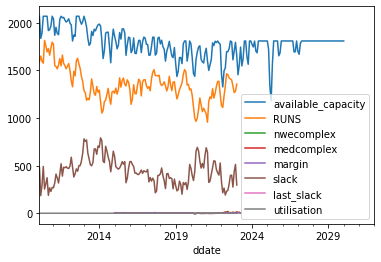

In [ ]:
data.xs('Italy').plot()

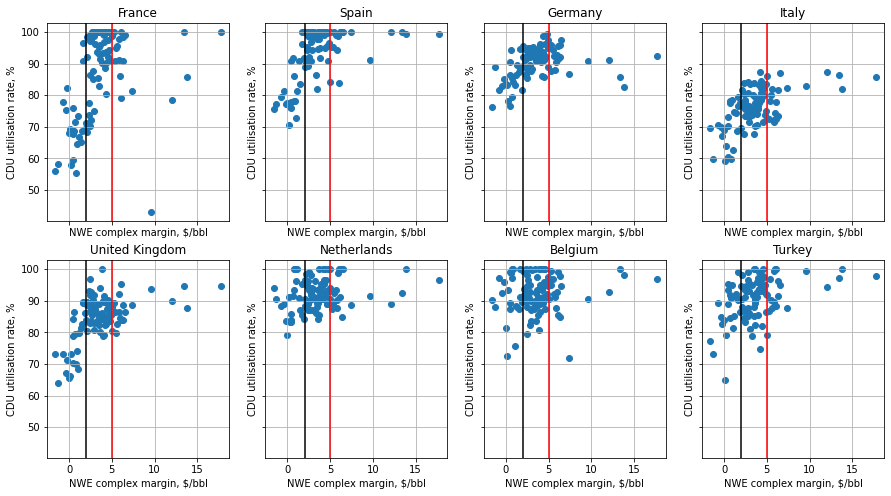

In [ ]:
import matplotlib.pyplot as plt
big_5 = ('France', 'Spain', 'Germany', 'Italy', 'United Kingdom', 'Netherlands', 'Belgium', 'Turkey')
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(15, 8))
for ax, country in zip(axes.flatten(), big_5):
    ax.scatter(x=data.xs(country)['nwecomplex'], y=data.xs(country)['utilisation'] * 100)
    ax.set_ylabel('CDU utilisation rate, %')
    ax.axvline(clip_margin, color='red')
    ax.axvline(2, color='black')
    ax.grid()
    ax.set_title(country)
    ax.set_xlabel('NWE complex margin, $/bbl')

In [ ]:
country_models = {country: sm.formula.ols('slack ~ margin', 
data = data.xs(country)).fit() for country in country_list}

In [ ]:
models = pd.Series(country_models)
best_models = models.apply(lambda x: x.rsquared).sort_values(ascending=False).round(2)
best_models

Spain             0.48
France            0.36
United Kingdom    0.34
Germany           0.34
Sweden            0.28
Ireland           0.21
Turkey            0.19
Lithuania         0.15
Italy             0.15
Slovakia          0.14
Switzerland       0.10
Austria           0.09
Portugal          0.07
Czech Republic    0.06
Netherlands       0.06
Denmark           0.03
Finland           0.02
Norway            0.02
Poland            0.02
Belgium           0.00
Hungary           0.00
Greece            0.00
dtype: float64

In [294]:
models.apply(lambda x: x.params).round(2).reindex(best_models.index).assign(ratio = lambda x: x['Intercept'] / x['margin'])

Intercept  margin       ratio
Spain              208.11  -38.65   -5.384476
France             286.41  -48.58   -5.895636
United Kingdom     283.24  -29.80   -9.504698
Germany            295.00  -33.06   -8.923170
Sweden              91.33  -11.54   -7.914211
Ireland             15.50   -1.46  -10.616438
Turkey             101.04  -11.39   -8.870939
Lithuania           30.88   -5.39   -5.729128
Italy              479.34  -21.75  -22.038621
Slovakia             4.77   -0.87   -5.482759
Switzerland         10.29   -1.03   -9.990291
Austria             22.50   -2.83   -7.950530
Portugal            83.41   -6.74  -12.375371
Czech Republic      28.50   -1.78  -16.011236
Netherlands        118.69   -8.20  -14.474390
Denmark             23.08   -0.98  -23.551020
Finland              8.51   -0.79  -10.772152
Norway              18.81   -2.43   -7.740741
Poland              11.50   -1.14  -10.087719
Belgium             59.53   -1.34  -44.425373
Hungary             14.74   -0.17  -86.705882
Greece              25.03    0.17  147.235294

In [300]:
snames = {k: k.lower().replace(" ", "_") for k in mapping}
formulas = (models
.apply(lambda x: x.params)
.assign(min_margin=lambda x: - x['Intercept'] / 10)
.assign(margin=lambda x: x['margin'].clip(upper=0))
.assign(saturn_name=lambda x: x.index.map(snames))
.assign(margin_name=lambda x: np.where(
    x.index.isin(NWE_countries), 
    "oil.petroineos.euromargin.nwecomplex.usd_bbl.monthly", 
    "oil.petroineos.euromargin.medcomplex.usd_bbl.monthly")
    )
)
formulas['slack_formula'] = formulas.apply(
    lambda x: f"""(add (series "oil.petroineos.{x['saturn_name']}.available_capacity_forecast.kbd.monthly") (* -1 (series "crude.jodi.{x['saturn_name']}.throughput.kbd.monthly")))""",axis=1)
formulas['slack_name'] = formulas.apply(
    lambda x: f"oil.petroineos.{x['saturn_name']}.cdu.slackness.kbd.monthly", axis=1)
# formulas['fslack_formula'] = formulas.apply(
#     lambda x: f"""(clip (dynamic_adjustment (priority (series "{x['slack_name']}") (/ (+ {x['Intercept']:.2f} (add (* {x['margin']:.2f} (clip (series "{x['margin_name']}") #:max {clip_margin} #:replacemax #t)))) {x['last_slack']:.2f})) {x['last_slack']:.2f}) #:min 0 #:replacemin #t)""",axis=1)
formulas['fslack_formula'] = formulas.apply(
    lambda x: f"""(clip (priority (series "{x['slack_name']}") (+ {x['Intercept']:.2f} (add (* {x['margin']:.2f} (clip (series "{x['margin_name']}") #:max {clip_margin} #:replacemax #t))))) #:min 0 #:replacemin #t)""",axis=1)
formulas['fslack_name'] = formulas.apply(
    lambda x: f"oil.petroineos.{x['saturn_name']}.cdu.slackness.kbd.monthly.forecast", axis=1)
formulas['fthrougphut_formula'] = formulas.apply(
    lambda x: f"""(add (* -1 (series "oil.petroineos.{x['saturn_name']}.cdu.slackness.kbd.monthly.forecast")) (series "oil.petroineos.{x['saturn_name']}.available_capacity_forecast.kbd.monthly"))""", axis=1)
formulas['fthrougphut_name'] = formulas.apply(
    lambda x: f"""oil.petroineos.{x['saturn_name']}.throughput_forecast2.kbd.monthly""", axis=1)
formulas.apply(lambda x: tsa.register_formula(x['slack_name'], x['slack_formula']), axis=1)
formulas.apply(lambda x: tsa.register_formula(x['fslack_name'], x['fslack_formula']), axis=1)#
formulas.apply(lambda x: tsa.register_formula(x['fthrougphut_name'], x['fthrougphut_formula']), axis=1)

Lithuania         None
Austria           None
Belgium           None
Denmark           None
Finland           None
France            None
Germany           None
Greece            None
Ireland           None
Italy             None
Netherlands       None
Norway            None
Portugal          None
Spain             None
Sweden            None
United Kingdom    None
Turkey            None
Czech Republic    None
Hungary           None
Poland            None
Slovakia          None
Switzerland       None
dtype: object

In [285]:
# http://tst-qdev-ap9.petroineos.local/tsview?series=crude.jodi.oecd_europe.throughput.kbd.monthly&series=crude.energy_aspects.oecd_europe.throughput.kbd.monthly&series=oil.petroineos.oecd_europe.throughput_forecast2.kbd.monthly